In [1]:
import numpy as np
import pandas as pd
import scipy

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Methods implementation

In [2]:
def a_priori_probab(y):
    label_set = set(y)
    a_priori = dict()
    for label in label_set:
        a_priori[label] = len(np.where(y == label)[0]) / len(y)
    return a_priori

def a_posteriori_probab(x, y, a=0, b=0):
    label_set = list(set(y))
    feature_set = list(set(x))
    a_posteriori = dict()
    for label in label_set:
        label_x = np.array([x[i] for i in range(len(y)) if y[i] == label])
        a_posteriori[label] = dict()
        for feature in feature_set:
            dividend = len(np.where(label_x == feature)[0]) + a
            divider = len(np.where(y == label)[0]) + a + b
            #print(dividend,'/',divider)
            a_posteriori[label][feature] = dividend / divider
    return a_posteriori

def a_posteriori_stats(x, y):
    label_set = list(set(y))
    a_posteriori = dict()
    for label in label_set:
        label_x = np.array([x[i] for i in range(len(y)) if y[i] == label])
        a_posteriori[label] = dict()
        a_posteriori[label]['mean'] = label_x.mean()
        a_posteriori[label]['std'] = label_x.std(ddof=1)
    return a_posteriori

#a_posteriori_probab(x,y)

In [3]:
def p_y(y, prior):
    return(prior[y])

def p_x(x, y, posterior, i, distrib='Bernulli'):
    if distrib == 'Bernulli':
        p = posterior[i][y][x]
    elif distrib == 'Gauss':
        p = scipy.stats.norm(posterior[i][y]['mean'], posterior[i][y]['std']).pdf(x)
    else:
        raise
        return
    return p

def naive_bayes_classifier(X, y, test_data, distrib='Bernulli'):
    prior = a_priori_probab(y)  # p(y)
    posterior = [None] * X.shape[1]
    i = 0
    if distrib == 'Bernulli':
        for x in X.T:
            posterior[i] = a_posteriori_probab(x,y)  # p(xi/y)
            i += 1
    elif distrib == 'Gauss':
        for x in X.T:
            posterior[i] = a_posteriori_stats(x,y)  # mean and std for f(xi/y)
            i += 1
    else:
        raise
        return
    labels_set = list(set(y))    
    y_pred = nb_predict(test_data, labels_set, prior, posterior, distrib)
    return y_pred

def nb_predict(X, labels_set, prior, posterior, distrib='Bernulli'):
    labels = []
    for x in X:
        probabilities = []
        for label in labels_set:
            nb_likelihood = np.array([p_x(x[i], label, posterior, i, distrib) 
                                      for i in range(len(x))]).prod()
            probabilities.append(nb_likelihood * p_y(label, prior))
        ind = np.array(probabilities).argmax()
        #ind = np.array([nb_likelihood(x, label, prior, posterior) \
        #                * p_y(label, prior) for label in labels_set]).argmax()
        labels.append(labels_set[ind])
    return np.array(labels)
    
def nb_likelihood(x, y, prior, posterior):
    return np.array([p_x(x[i], y, posterior, i) 
                     for i in range(len(x))]).prod()

# Quality check

In [4]:
def accuracy(y, y_pred):
    return np.array([1 if y_pred[i] == y[i] else 0
                     for i in range(len(y))]).sum() / len(y)

#  Visualizing algorithms results

In [5]:
def plot_2f_dataset(data, labels, colors=None): 
    from numpy.random import rand
    data = np.array(data)
    labels = np.array(labels)
    n = len(set(labels))
    if(colors == None):
        colors = ListedColormap([tuple(rand(3)) for i in range(n)])
    pyplot.figure(figsize(5, 5))
    pyplot.scatter(data[:,0], data[:,1], c = labels, cmap = colors)
    plt.show()

In [6]:
def print_result(true, predict, cut = 5):
    #print('w:\n',coef,'\n')
    if len(true) > cut:
        nl = '\n...\n'
    else:
        nl = '\n'
    print('true vs. prediction:\n',vstack((true,predict)).T[:cut],nl)
    print('accuracy: ',round(accuracy(true, predict),3))

# 1. Features are categorial

### Import custom dataset "Weather-Play"

In [7]:
data_frame = pd.read_csv('Data/weather-play.csv')

features = ['Weather']
labels = ['Play']
data = np.array(data_frame[features].values, dtype='str')
target = np.array(data_frame[labels].values, dtype='str')
target = target.reshape(target.shape[0])
train_data = test_data = data
train_labels = test_labels = target

In [8]:
print('train_data: \n',train_data[:5],'\n...\n')
print('train_labels: \n',train_labels[:5],'...')

train_data: 
 [['Sunny']
 ['Overcast']
 ['Rainy']
 ['Sunny']
 ['Sunny']] 
...

train_labels: 
 ['No' 'Yes' 'Yes' 'Yes' 'Yes'] ...


### Run model and output

In [9]:
test_labels_predict = naive_bayes_classifier(train_data, train_labels,
                                             test_data, distrib='Bernulli')

print_result(test_labels, test_labels_predict, cut = 10)
if train_data.shape[1] == 2 and (train_data.dtype.type == np.float64
                                 or train_data.dtype.type == np.int64):
    #plot_2f_dataset(train_data, train_labels_predict)
    plot_2f_dataset(test_data, test_labels_predict)

true vs. prediction:
 [['No' 'Yes']
 ['Yes' 'Yes']
 ['Yes' 'No']
 ['Yes' 'Yes']
 ['Yes' 'Yes']
 ['Yes' 'Yes']
 ['No' 'No']
 ['No' 'No']
 ['Yes' 'Yes']
 ['Yes' 'No']] 
...

accuracy:  0.714


# 2. Features are real

### Generate / Import dataset

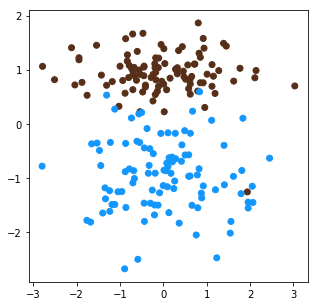

In [28]:
from sklearn import datasets

sample_size = 200
data, target = datasets.make_classification(n_samples=sample_size, n_features=2, 
                                            n_informative=1, n_redundant=0, 
                                            n_repeated=0, n_classes=2, 
                                            n_clusters_per_class=1, 
                                            weights=None, flip_y=0.01, 
                                            class_sep=1.0, hypercube=True, 
                                            shift=0.0, scale=1.0, 
                                            shuffle=True, random_state=1)
#w = datasets.load_wine()
#data, target = w.data, w.target
plot_2f_dataset(data, target)

### Split dataset into train & test samples

In [29]:
from sklearn import cross_validation as cross_val

train_data, test_data, \
train_labels, test_labels = cross_val.train_test_split(data, target,
                                                       test_size = 0.3)

In [30]:
print('train_data: \n',train_data[:5],'\n...\n')
print('train_labels: \n',train_labels[:5],'...')

train_data: 
 [[ 1.62284909  0.7894945 ]
 [ 0.09542509 -1.16206807]
 [-0.68067814 -0.86502859]
 [ 0.42952614 -0.38841561]
 [ 1.76795995  1.02592854]] 
...

train_labels: 
 [1 0 0 0 1] ...


### Run model and output

true vs. prediction:
 [[1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]] 
...

accuracy:  0.9


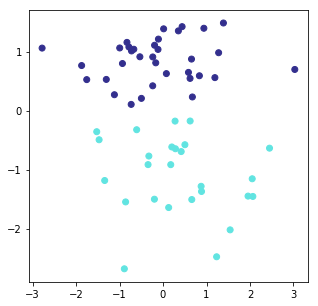

In [34]:
test_labels_predict = naive_bayes_classifier(train_data, train_labels,
                                             test_data, distrib='Gauss')

print_result(test_labels, test_labels_predict, cut = 10)
if train_data.shape[1] == 2 and (train_data.dtype.type == np.float64
                                 or train_data.dtype.type == np.int64):
    #plot_2f_dataset(train_data, train_labels_predict)
    plot_2f_dataset(test_data, test_labels_predict)

### sklearn.naive_bayes.GaussianNB for check

true vs. prediction:
 [[1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]] 
...

accuracy:  0.9


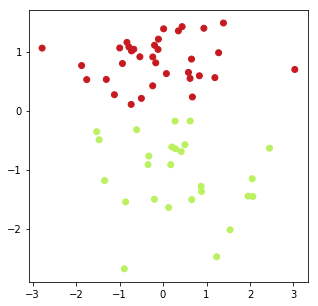

In [32]:
from sklearn import naive_bayes

Gaussian_NB_classifier = naive_bayes.GaussianNB()
Gaussian_NB_classifier.fit(train_data,train_labels)
print_result(test_labels, Gaussian_NB_classifier.predict(test_data))
if train_data.shape[1] == 2 and (train_data.dtype.type == np.float64
                                 or train_data.dtype.type == np.int64):
    #plot_2f_dataset(train_data, Gaussian_NB_classifier.predict(train_data))
    plot_2f_dataset(test_data, Gaussian_NB_classifier.predict(test_data))